In [19]:
from flask import Flask, request, jsonify
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.applications.xception import Xception, preprocess_input

In [20]:
def xception_preprocessing(img):
    return preprocess_input(img)

# Function to build the model architecture
def build_model():
    base_model = Xception(include_top=False, input_tensor=Input(shape=(320, 320, 3)), weights=None)
    base_model.trainable = False  # Make the base model non-trainable

    model = Sequential([
        Input(shape=(320, 320, 3)),  # Explicitly define an Input layer
        Lambda(preprocess_input, name='preprocessing'),
        base_model,
        GlobalAveragePooling2D(),
        Dense(12, activation='softmax')  # Assuming there are 12 classes
    ])
    return model

class_info = {
    0: {"name": "Paper", "recycling_instructions": "Drop off at any recycling bin designated for paper. Ensure it is dry and free from food residue."},
    1: {"name": "Cardboard", "recycling_instructions": "Flatten boxes and remove any non-paper packing materials."},
    2: {"name": "Plastic", "recycling_instructions": "Rinse and sort plastics by number. Check local facilities for specific types accepted."},
    3: {"name": "Metal", "recycling_instructions": "Clean and sort by type. Most metals like aluminum and steel can be recycled curbside."},
    4: {"name": "Trash", "recycling_instructions": "Not recyclable. Dispose of as general waste."},
    5: {"name": "Battery", "recycling_instructions": "Batteries should be recycled at designated drop-off locations due to hazardous materials."},
    6: {"name": "Shoes", "recycling_instructions": "Donate if in good condition or recycle at textile recycling points."},
    7: {"name": "Clothes", "recycling_instructions": "Donate wearable clothes or recycle at textile recycling points."},
    8: {"name": "Green Glass", "recycling_instructions": "Rinse and recycle at glass recycling points."},
    9: {"name": "Brown Glass", "recycling_instructions": "Rinse and recycle at glass recycling points."},
    10: {"name": "White Glass", "recycling_instructions": "Rinse and recycle at glass recycling points."},
    11: {"name": "Biological", "recycling_instructions": "Compost if possible, or dispose of in biodegradable waste bins."}
}

In [21]:
model = build_model()
model.load_weights('eco-track.h5')

In [32]:
manifest_df = pd.read_csv("manifest_df.csv")
del manifest_df[manifest_df.columns[0]]
manifest_df

,filename,category,set
0,clothes/clothes2132.jpg,clothes,1
1,battery/battery850.jpg,battery,1
2,metal/metal41.jpg,metal,1
3,cardboard/cardboard282.jpg,cardboard,1
4,cardboard/cardboard198.jpg,cardboard,1
...,...,...,...
13959,clothes/clothes5293.jpg,clothes,0
13960,brown-glass/brown-glass584.jpg,brown-glass,0
13961,clothes/clothes1428.jpg,clothes,0
13962,trash/trash578.jpg,trash,0


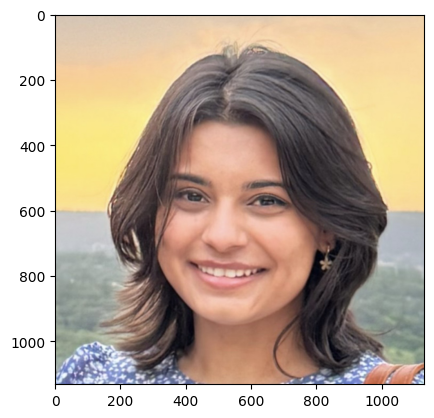

In [22]:
test_image = 'test_img/IMG_2355.jpg'
image = Image.open(test_image).convert('RGB')
plt.imshow(image)

In [34]:
test_df = test_df.reset_index(drop=True)
test_df['actual']

,filename,category,set
0,biological/biological228.jpg,biological,0
1,cardboard/cardboard62.jpg,cardboard,0
2,clothes/clothes62.jpg,clothes,0
3,brown-glass/brown-glass312.jpg,brown-glass,0
4,cardboard/cardboard657.jpg,cardboard,0
...,...,...,...
1547,clothes/clothes5293.jpg,clothes,0
1548,brown-glass/brown-glass584.jpg,brown-glass,0
1549,clothes/clothes1428.jpg,clothes,0
1550,trash/trash578.jpg,trash,0


In [24]:
image = image.resize((320, 320))
image = np.array(image)
image = np.expand_dims(image, axis=0)



In [ ]:
test_predict = []

for i in test_df['filename']:
    test_image = i
    image = Image.open(test_image).convert('RGB')
    image = image.resize((320, 320))
    image = np.array(image)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    predicted_class = np.argmax(prediction, axis=1)[0]
    test_predict.append(predicted_class)
    

In [26]:
prediction = model.predict(image)
predicted_class = np.argmax(prediction, axis=1)[0]
predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


4

In [ ]:


        


        app.logger.info(f'Predicted class: {predicted_class}')
        
        class_data = class_info.get(predicted_class, {"name": "Unknown", "recycling_instructions": "No instructions available."})
        app.logger.info(f'Class data retrieved: {class_data}')
        
        return jsonify({
            'predicted_class': int(predicted_class), 
            'class_name': class_data['name'], 
            'recycling_instructions': class_data['recycling_instructions']
        })
    except Exception as e:
        app.logger.error(f'Error processing image: {type(e).__name__}, {str(e)}')
        return jsonify({'error': f'Error processing image: {type(e).__name__}', 'message': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True, port=5000)
